In [1]:
import pprint
import time

import zmq
from sympy.physics.units import current

ctx = zmq.Context()
# The REQ talks to Pupil remote and receives the session unique IPC SUB PORT
socket = ctx.socket(zmq.REQ)

ip = 'localhost'
port = 50020

socket.connect(f'tcp://{ip}:{port}')

# Request 'SUB_PORT' for reading data
socket.send_string('SUB_PORT')
sub_port = socket.recv_string()

# Request 'PUB_PORT' for writing data
socket.send_string('PUB_PORT')
pub_port = socket.recv_string()

socket.close()

In [2]:
def create_socket(ctx_c, ip_c, topics):
    sub = ctx_c.socket(zmq.SUB)
    sub.connect(f'tcp://{ip_c}:{sub_port}')
    for topic in topics:
        sub.subscribe(topic)
    return sub

In [80]:
import cv2
import msgpack
import pprint
import numpy as np


socket_fixation = create_socket(ctx, ip, ['fixation'])


fixation_pos_arr = []
for i in range(5):
    fixation = socket_fixation.recv_multipart()
    origin = msgpack.loads(fixation[1]).get('norm_pos', None)
    fixation_pos_arr.append(origin)

origin = np.mean(fixation_pos_arr, axis=0)

socket_frame = create_socket(ctx, ip, ['frame.world'])
frame = socket_frame.recv_multipart()
# decode the image as np array in rgb using numpy


gaze_socket = create_socket(ctx, ip, ['gaze.'])

gaze_data = []

for i in range(600):
    topic, payload = gaze_socket.recv_multipart()
    message = msgpack.loads(payload)
    gaze_data.append(message)

pprint.pprint(gaze_data[2])

# close the sockets
gaze_socket.close()
socket_fixation.close()

{'base_data': [{'circle_3d': {'center': [-4.304952694904472,
                                         -0.9165673961173268,
                                         40.41333119090427],
                              'normal': [-0.22855655358534868,
                                         0.14767088921874716,
                                         -0.9622656651312734],
                              'radius': 1.876361413836778},
                'confidence': 0.7866132430497075,
                'diameter': 29.282459023657637,
                'diameter_3d': 3.752722827673556,
                'ellipse': {'angle': 155.77026097371606,
                            'axes': [27.838330256563385, 29.282459023657637],
                            'center': [64.00002528215552, 89.88011140382187]},
                'id': 0,
                'location': [64.00002528215552, 89.88011140382187],
                'method': 'pye3d 0.3.2 real-time',
                'model_confidence': 1.0,
                'norm


0: 384x640 1 HueLampWhiteHalfRound, 15.5ms
Speed: 3.4ms preprocess, 15.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


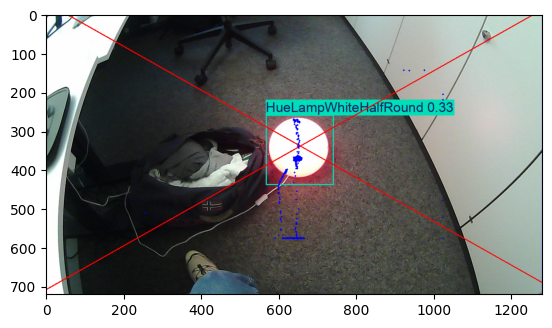

In [85]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

img = cv2.imdecode(np.frombuffer(frame[2], dtype=np.uint8), cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = Image.fromarray(img)
model = YOLO("../.local/models/object_detection/yolov11n_trained.pt", verbose=False)
results = model.predict(img)

img = results[0].plot(pil=True)
img = np.array(img)
img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)


l1 = [origin[0] - 2, origin[1] + 2]
l2 = [origin[0] - 2, origin[1] - 2]
r1 = [origin[0] + 2, origin[1] + 2]
r2 = [origin[0] + 2, origin[1] - 2]

# plot lines between the origin and l1, l2 on the frame
# compute the image coordinates of the origin
origin_img = (int(origin[0] * img.shape[1]), int(origin[1] * img.shape[0]))

# compute the image coordinates of l1, l2, r1, r2
l1_img = (int(l1[0] * img.shape[1]), int(l1[1] * img.shape[0]))
l2_img = (int(l2[0] * img.shape[1]), int(l2[1] * img.shape[0]))
r1_img = (int(r1[0] * img.shape[1]), int(r1[1] * img.shape[0]))
r2_img = (int(r2[0] * img.shape[1]), int(r2[1] * img.shape[0]))

# plot the lines
cv2.line(img, origin_img, l1_img, (255, 0, 0), 2)
cv2.line(img, origin_img, l2_img, (255, 0, 0), 2)
cv2.line(img, origin_img, r1_img, (255, 0, 0), 2)
cv2.line(img, origin_img, r2_img, (255, 0, 0), 2)

# plot the gaze points
gaze_norm_pos = np.array([[data['norm_pos'][0], 1 - data['norm_pos'][1]] for data in gaze_data])

# clip the gaze points to the screen
gaze_norm_pos = np.clip(gaze_norm_pos, 0.2, 0.8)

gaze_img_pos = (gaze_norm_pos * np.array([img.shape[1], img.shape[0]])).astype(int)
for pos in gaze_img_pos:
    # plot the gaze points and make the color map over time
    cv2.circle(img, tuple(pos), 2, (0, 0, 255), -1)

# load the image with numpy and show it
plt.imshow(np.array(img))



False


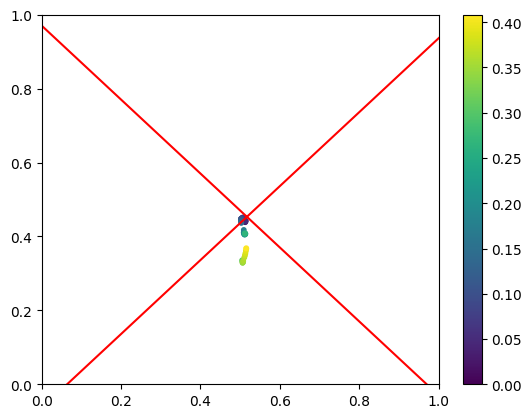

In [62]:
import matplotlib.pyplot as plt
import numpy as np

l1 = [origin[0] - 2, origin[1] + 2]
l2 = [origin[0] - 2, origin[1] - 2]
r1 = [origin[0] + 2, origin[1] + 2]
r2 = [origin[0] + 2, origin[1] - 2]

# check if the fixation point is in one of the areas seperated by the vectors passing the origin and the corners of the screen
def is_point_in_triangle(p1, p2, p3, p):
    def sign(a, b, c):
        return (a[0] - c[0]) * (b[1] - c[1]) - (b[0] - c[0]) * (a[1] - c[1])

    b1 = sign(p, p1, p2) < 0.0
    b2 = sign(p, p2, p3) < 0.0
    b3 = sign(p, p3, p1) < 0.0

    return ((b1 == b2) and (b2 == b3))



gaze_norm_pos = np.array([data['norm_pos'] for data in gaze_data])
avg_gaze = gaze_norm_pos.mean(axis=0)
print(is_point_in_triangle(l2, l1, origin, avg_gaze))

# use colormap to show the order of the gaze points
plt.scatter(gaze_norm_pos[:, 0], gaze_norm_pos[:, 1], s=10, c=np.arange(len(gaze_norm_pos))/120, cmap='viridis')
# plot lines from the origin to the corners of the screen
plt.plot([origin[0], l1[0]], [origin[1], l1[1]], color='r')
plt.plot([origin[0], l2[0]], [origin[1], l2[1]], color='r')
plt.plot([origin[0], r1[0]], [origin[1], r1[1]], color='r')
plt.plot([origin[0], r2[0]], [origin[1], r2[1]], color='r')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.colorbar()
plt.show()

In [ ]:
pupil_0_diameter, pupil_1_diameter = [], []
for data in gaze_data:
    base_data = data['base_data']
    if len(base_data) == 2:
        if base_data[0]['id'] == 0:
            pupil_0_diameter.append(base_data[0]['diameter'])
            pupil_1_diameter.append(base_data[1]['diameter'])
        else:
            pupil_0_diameter.append(base_data[1]['diameter'])
            pupil_1_diameter.append(base_data[0]['diameter'])
    else:
        print('Error: base_data length is not 2')
        pupil_0_diameter.append(np.nan)
        pupil_1_diameter.append(np.nan)

# create a fig with 4 subplots below each other and size 10x5
fig, axs = plt.subplots(4, 1, figsize=(10, 10))

# plot the pupil diameters
axs[0].plot(pupil_0_diameter, label='Pupil 0', color='r')
axs[0].set_xlabel('time [s]')
axs[0].set_ylabel('diameter [mm]')
axs[0].set_ylim(20, 35)

axs[1].plot(pupil_1_diameter, label='Pupil 1', color='b')
axs[1].set_xlabel('time [s]')
axs[1].set_ylabel('diameter [mm]')
axs[1].set_ylim(20, 35)

axs[2].plot(gaze_norm_pos[:, 0], label='Position X', color='g')
axs[2].set_xlabel('time [s]')
axs[2].set_ylabel('norm_pos X')
axs[2].set_ylim(-0.5, 1.5)

axs[3].plot(gaze_norm_pos[:, 1], label='Position Y', color='m')
axs[3].set_xlabel('time [s]')
axs[3].set_ylabel('norm_pos Y')
axs[3].set_ylim(-0.5, 1.5)

# set the title for the figure
fig.suptitle('$\mathbf{Fixation}$ during head movement $\mathbf{LEFT}$')

# add a legend to the figure
fig.legend()

# adjust the layout of the figure
fig.tight_layout()

# show the figure
plt.show()
fig.savefig('../.local/plots/head_movement/fixation_during_head_movement_left.png')
